<a href="https://colab.research.google.com/github/fatimahaidara/NLP_wit_Disaster_Tweets/blob/main/Logistic_reg_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets 

## <a id='basic'>1. Introduction



This project has the goal to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, with access to a dataset of 10,000 tweets that were hand classified ([Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)). 

## <a id='basic'>2. Data Importing






**2.1 Train and Test Set Importing**

First, we import the necessary libraries and training and test sets

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import re # Regular expressions'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

plt.rcParams.update({'font.size': 14})

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report


# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

# Keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import GlobalAveragePooling1D,Lambda,Input,GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D,TimeDistributed

In [45]:
# Load data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sub_sample = pd.read_csv("/content/sample_submission.csv")

In [46]:
print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


## <a id='basic'>3. Basic Exploration</a>

In [47]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:
train.duplicated().sum()

0

There are 52 duplicated rows. The duplicates will be removed.

In [49]:
train = train.drop_duplicates().reset_index(drop=True)

Lets Visualize with the class imbalance thing !

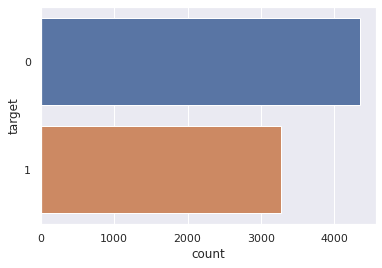

In [50]:
sns.countplot(y=train.target);

In [51]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [52]:
# NA data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [53]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

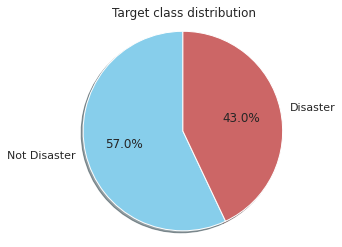

In [54]:
# Criando a representação, área de plot
fig1, ax1 = plt.subplots(figsize = (4,4))

# Conjunto de dados a ser representado
sns.set(style="darkgrid")
targets = train.target.value_counts()
labels = ['Not Disaster', 'Disaster']

# Criando o gŕafico
ax1.pie(targets, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90, colors = ['skyblue',(0.8,0.4,0.4)])

# Opções Adicionais
plt.title('Target class distribution')
ax1.axis('equal')

# Mostrando o gŕafico
plt.show()

From the above evaluation we understand that Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

## <a id='keyword'>4. Keywords</a>

In [55]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
print (set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


Train and test have the same set of keywords

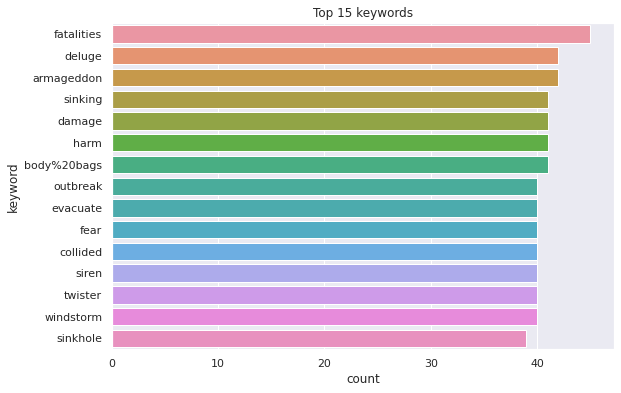

In [56]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

There is no common top 10 keywords between disaster and non-disaster tweets.

## <a id='location'>5. Locations</a>

In [57]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


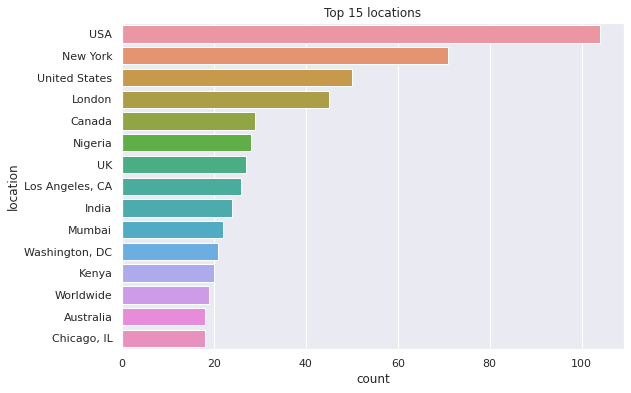

In [58]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.
The top 3 locations with highest % of disaster tweets are **Mumbai, Inida, and Nigeria**. As the location data is not clean, we see some interesting cases, such as **'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average**. We try to clean up the location and see if there is any difference:

## <a id='location'>6.Data Preprocessing Part

In [59]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'

    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

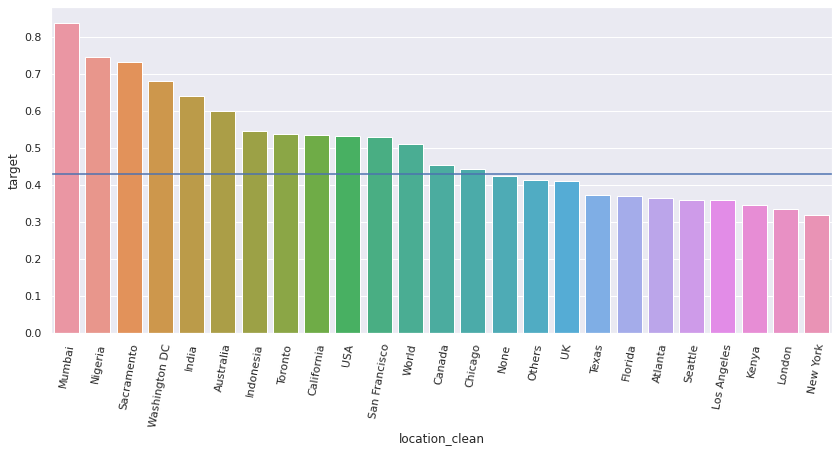

In [60]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

## <a id='location'>7.Cleaning the Data

Clean up Text Column</a>

Here we clean up the text column by:
- Making a 'clean' text column, removing links and unnecessary white spaces
- Creating separate columns containing lists of hashtags, mentions, and links

In [61]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [62]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

## <a id='location'>8. Create statistics from texts</a>

In [63]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 19) (3263, 18)


In [64]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

All of the statistics have very low correlation with the target variable

## <a id='gram'>7. Most frequent words and bigrams</a>

What are the most common unigrams (single word) and bigrams (two-word sequence)?

# WordCloud

In [65]:
def generate_display_wordclouds(dataframe):
    full_text_non_disaster = ''.join(dataframe[dataframe['target'] == 0].text)
    full_text_disaster = ''.join(dataframe[dataframe['target'] == 1].text)

        
    wc_not_disaster = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)
    
    wc_disaster = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)
    
    wc_not_disaster.generate(full_text_non_disaster)
    wc_disaster.generate(full_text_disaster)
    
    
    fig, axes = plt.subplots(figsize = [20,8], nrows = 1, ncols = 2)
    
    axes[0].imshow(wc_not_disaster, interpolation = 'bilinear')
    axes[1].imshow(wc_disaster, interpolation = 'bilinear')
    axes[0].axis("off")
    axes[1].axis("off")
    
    
    axes[0].set_title('Not Disaster')
    axes[1].set_title('Disaster')
    

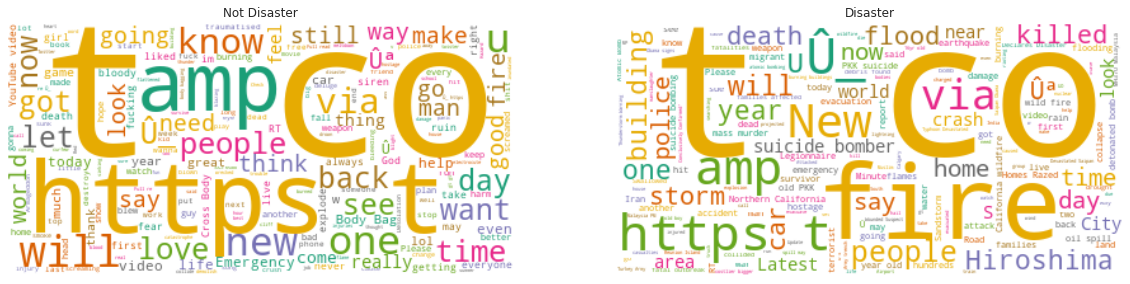

In [66]:
generate_display_wordclouds(train)

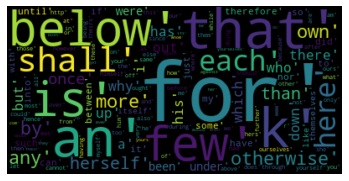

In [67]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist, word_tokenize

# Make a list of stop words
stopwords = str(STOPWORDS)
wc = WordCloud().generate(stopwords)
 
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## <a id='encode'>8.Feature Engineering

##  Encoding and Vectorizers</a>

As part of feature generation, we will:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [68]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


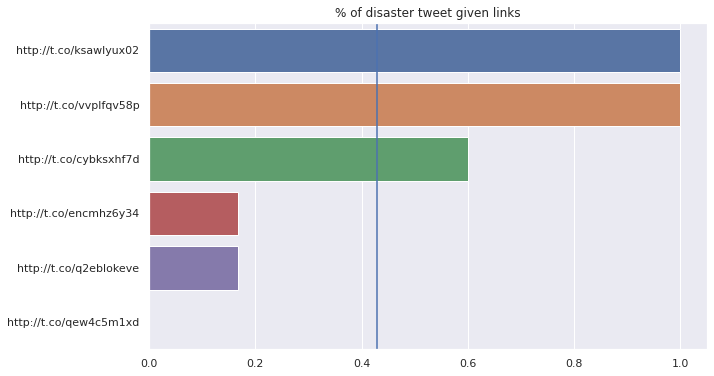

In [70]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('% of disaster tweet given links')
plt.show()

In [71]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['abstorm', 'earthquake', 'hiroshima', 'india', 'japan', 'libya', 'africa', 'mumbai', 'myanmar', 'newyork', 'okwx', 'rohingya', 'science', 'sittwe', 'socialnews', 'wildfire', 'wildfires', 'worldnews', 'wx', 'hailstorm', 'mh370', 'yyc', 'disaster', 'breaking', 'bestnaijamade', 'antioch']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['dubstep', 'edm', 'animalrescue', 'fashion', 'technology', 'dance', 'trapmusic', 'ices', 'np', 'job', 'jobs', 'summerfate', 'kindle', 'soundcloud', 'military', 'bb17', 'beyhive', 'dnb']
Total: 18


## <a id='encode'>9.TD IDF Count vectorizer

In [72]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [73]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1841) (3263, 1840)


## <a id='simple'>10. Regression Technique

## Logistic Regression</a>

We try the simplest model with logistic regression, based on all features we created above. Before we fit a model, we first transform the features into the same scale with minimum 0 and maximum 1. We do this in the form of pipeline.

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline_lr= Pipeline([('scale',scaler), ('lr', lr),])

pipeline_lr.fit(X_train, y_train)
y_test = pipeline_lr.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [75]:
print ('Training accuracy: %.4f' % pipeline_lr.score(X_train, y_train))

Training accuracy: 0.8538


In [76]:
print ('Testing accuracy: %.4f' % pipeline_lr.score(X_test, y_test))

Testing accuracy: 1.0000


# F1 SCORE

In [77]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline_lr.predict(X_train)))


Training f-1 score: 0.8165


# Confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
pd.DataFrame(confusion_matrix(y_train, pipeline_lr.predict(X_train)))

,0,1
0,4023,319
1,794,2477


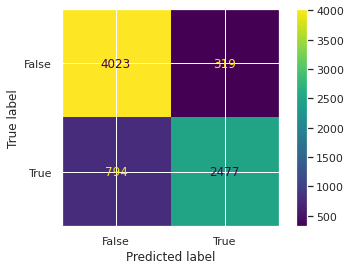

In [79]:
confusion_matrix = confusion_matrix(y_train, pipeline_lr.predict(X_train))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

This forms the basis of evaluating and modifying our models in the next section.

# Hypertuning

## Evaluate and Improve Our Model</a>

Several things will be done:
- Cross validation with shuffle split
- Feature selections
- Grid search for hyperparameters
- Identify errors

Reference: [scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [80]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline_lr, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.743


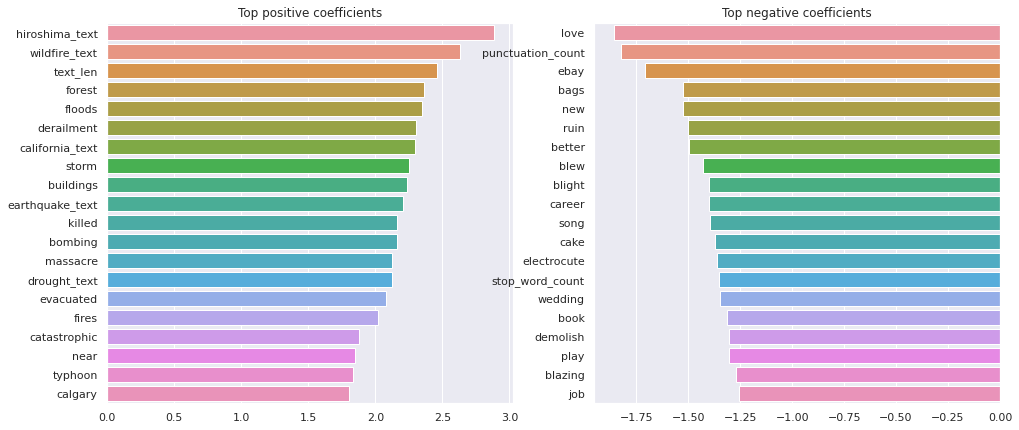

In [81]:
# Top features
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

Findings:
- 'keyword_target' is the top positive coefficient, meaning the keyword column made a good feature
- hiroshima both as text and hashtag made the top 20 positive coefficients
- Punctuation count and stop word count are among top 20 negative coefficients
- None of the bigrams made the top features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


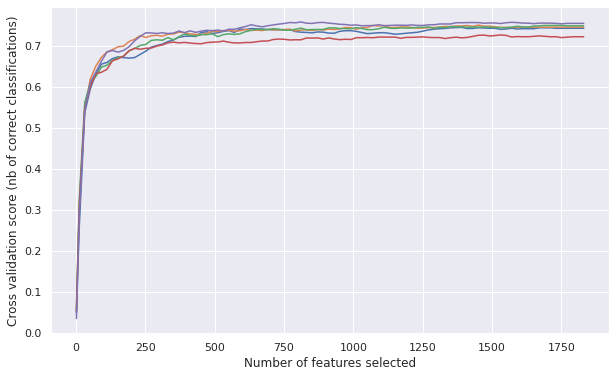

In [82]:
# Feature selection
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [83]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

In [84]:
pipeline_lr.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline_lr, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

Cross validation F-1 score: 0.757


A little improvement from the earlier model

In [85]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv2, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.757


Default hyperparameters gave the best score.

# Output data for Submission

In [86]:
# Submit fine-tuned model

y_test2 = pipeline_grid.predict(X_test2)
submit2 = sub_sample.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)